In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier #Gradient booster classifier

## **Load the data**
### Load train dataset

In [ ]:
train = pd.read_csv("../input/reducing-commercial-aviation-fatalities/train.csv")

In [ ]:
train.sample(5)

In [ ]:
print(train.shape)

### Load test dataset

In [ ]:
test_iterator = pd.read_csv("../input/reducing-commercial-aviation-fatalities/test.csv", chunksize=5)
test_top = next(test_iterator)

In [ ]:
test_top

In [ ]:
sample_sub = pd.read_csv("../input/reducing-commercial-aviation-fatalities/sample_submission.csv")
sample_sub.sample(10)

## Explore Training Data

In [ ]:
pd.crosstab(train.experiment, train.event)

### To have an idea of how the records were distributed among the crews

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(train['event'])
plt.xlabel("State of the pilot", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.title("Target repartition", fontsize = 15)
plt.show()

In [ ]:
pd.crosstab(train.experiment, train.crew)

#### Just to remember the indexes of the columns

In [ ]:
print(list(enumerate(train.columns)))

### Filtering the training set. We can play with the crews, seats, exp, and event

In [ ]:
crew = 3
seat = 0
exp = 'DA'
ev = 'D'

sel = (train.crew == crew) & (train.experiment) & (train.seat == seat)
pilot_info = train.loc[sel, :].sort_values(by = 'time')

plt.figure(figsize = [16, 12])
for i in range(4, 27):
    plt.subplot(6, 4, i-3)
    plt.plot(pilot_info.time, pilot_info.iloc[:, i], zorder = 1)
    plt.scatter(pilot_info.loc[pilot_info.event == ev, :].time, pilot_info.loc[pilot_info.event == ev, :].iloc[:, i], 
                c = 'red', zorder = 2, s = 1)
    plt.title(pilot_info.columns[i])
    
plt.tight_layout()
plt.show()

## Create Feature and Label Arrays
### Create the Montages for Train and Test sets

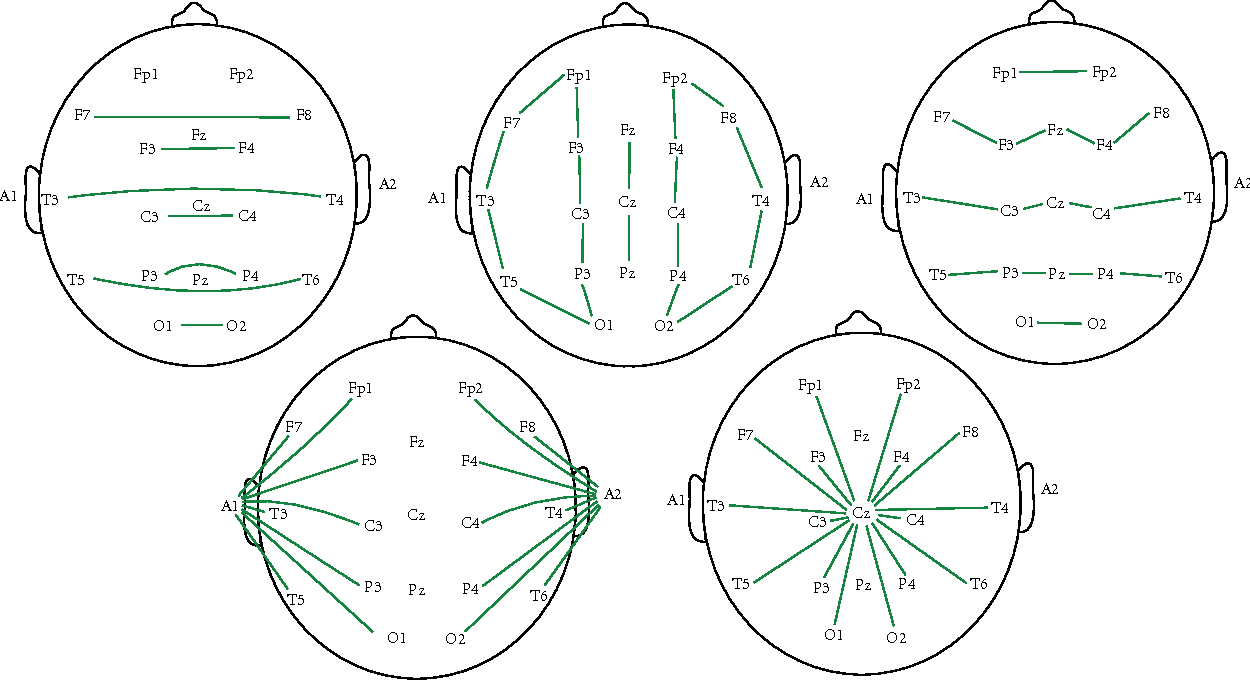

In [ ]:
train['f7-f8'] = train['eeg_f7'] - train['eeg_f8']
train['f3-f4'] = train['eeg_f3'] - train['eeg_f4']
train['t3-t4'] = train['eeg_t3'] - train['eeg_t4']
train['c3-c4'] = train['eeg_c3'] - train['eeg_c4']
train['p3-p4'] = train['eeg_p3'] - train['eeg_p4']
train['t5-t6'] = train['eeg_t5'] - train['eeg_t6']
train['o1-o2'] = train['eeg_o1'] - train['eeg_o2']

train_columns = ['crew', 'seat', 'f7-f8', 'f3-f4', 't3-t4', 'c3-c4', 'p3-p4', 't5-t6', 'o1-o2', 
                 'ecg', 'r', 'gsr', 'event']
train = train.loc[:, train_columns]
train.sample(5)

In [ ]:
test_top['f7-f8'] = test_top['eeg_f7'] - test_top['eeg_f8']
test_top['f3-f4'] = test_top['eeg_f3'] - test_top['eeg_f4']
test_top['t3-t4'] = test_top['eeg_t3'] - test_top['eeg_t4']
test_top['c3-c4'] = test_top['eeg_c3'] - test_top['eeg_c4']
test_top['p3-p4'] = test_top['eeg_p3'] - test_top['eeg_p4']
test_top['t5-t6'] = test_top['eeg_t5'] - test_top['eeg_t6']
test_top['o1-o2'] = test_top['eeg_o1'] - test_top['eeg_o2']

test_columns = ['id', 'crew', 'seat', 'f7-f8', 'f3-f4', 't3-t4', 'c3-c4', 'p3-p4', 't5-t6', 'o1-o2', 
                 'ecg', 'r', 'gsr']
test_columns = test_top.loc[:, test_columns]
test_columns

In [ ]:
y_train_full = train.event
X_train_full = train.iloc[:, :-1]
X_train_full.head()

In [ ]:
pd.DataFrame({
    'min_val':X_train_full.min(axis=0).values,
    'max_val':X_train_full.max(axis=0).values,
    }, index = X_train_full.columns
)

### Generates a Frequency Distribution for a Colum

In [ ]:
y_train_full.value_counts()

### We take those counts from previous cell and convert them into proportions

In [ ]:
y_train_full.value_counts() / len(y_train_full)

### Split the Training Dataset into Training and Validation

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.90, stratify = y_train_full, random_state = 1)
#print(X_train.shape)
print(f"Training on {X_train.shape[0]} samples.")

## Logistic Regression Model

In [ ]:
%%time
lr_mod = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr_mod.fit(X_train, y_train)

print('Training Accuracy: ', lr_mod.score(X_train, y_train))
print('Validation Accuracy: ', lr_mod.score(X_valid, y_valid))

## Logistic Regression with GridSearchCV to see if we can have better results

In [ ]:
# It didn't improve the model anyway
#%%time
#lr_pipe = Pipeline(
#    steps = [
#        ('scaler', StandardScaler()),
#        ('classifier', LogisticRegression(solver = 'lbfgs', n_jobs = -1))
#    ]
#)
#lr_param_grid = {
#    'classifier__C':[0.001, 0.1, 1.0, 1.1],
#}
#np.random.seed(1)
#grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv = 10, refit = 'True')
#grid_search.fit(X_train, y_train)
#
#print(grid_search.best_score_)
#print(grid_search.best_params_)

## Random Forest Classifier

In [ ]:
%%time
rf_mod1 = RandomForestClassifier(n_estimators = 20, max_depth = 32, n_jobs = -1)
rf_mod1.fit(X_train, y_train)

print('Training Accuracy: ', rf_mod1.score(X_train, y_train))
print("Validation Accuracy: ", rf_mod1.score(X_valid, y_valid))

### Hyperparameter Tuning and we will get the average of the CV scores

In [ ]:
%%time
rf_pipe = Pipeline(
    steps =[
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=40, n_jobs=-1))
    ]
)
lr_param_grid = {
    'classifier__max_depth':[65, 66, 67]
}
np.random.seed(1)
grid_search = GridSearchCV(rf_pipe, lr_param_grid, cv = 5, refit = 'True')
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
grid_search.cv_results_['mean_test_score']

### Increasing the number of estimators for the max_depth = 66

In [ ]:
%%time
rf_mod = RandomForestClassifier(n_estimators = 150, max_depth=66, n_jobs = -1)
rf_mod.fit(X_train, y_train)

print('Training Accuracy: ', rf_mod.score(X_train, y_train))
print('Validation Accuracy: ', rf_mod.score(X_valid, y_valid))

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_train, rf_mod.predict_proba(X_train))

In [ ]:
log_loss(y_valid, rf_mod.predict_proba(X_valid))

## Gradient Boosting Tree

In [ ]:
#%%time
#xbg_mod = XGBClassifier()
#xbg_mod.fit(X_train, y_train)

#xbg_mod.score(X_train, y_train)

### Score in the other 98% of the data

In [ ]:
#xbg_mod.score(X_valid, y_valid)

In [ ]:
#log_loss(y_train, xbg_mod.predict_proba(X_train))

In [ ]:
#log_loss(y_valid, xbg_mod.predict_proba(X_valid))

## Hyperparameter Tuning for Gradient Boosting

In [ ]:
%%time
xgd_pipe = Pipeline(
    steps = [
        ('classifier', XGBClassifier(learning_rate = 0.3, alpha=1, max_depth=6, n_estimators=30, subsample=0.5))
    ]
)
xgd_param_grid = {
    'classifier__learning_rate':[0.7, 0.8, 0.9, 0.10],
}
np.random.seed(1)
xgd_grid_search = GridSearchCV(xgd_pipe, xgd_param_grid, cv=5, refit='True')
xgd_grid_search.fit(X_train, y_train)

print(xgd_grid_search.best_score_)
print(xgd_grid_search.best_params_)

## Generate Test Predictions

In [ ]:
#test_iteratorator = pd.read_csv("../input/reducing-commercial-aviation-fatalities/test.csv", chunksize=5)
#test_top = next(test_iterator)
#test_top

In [ ]:
%%time
cs = 10000
i = 0
for test in pd.read_csv("../input/reducing-commercial-aviation-fatalities/test.csv", chunksize=cs):
    test['f7-f8'] = test['eeg_f7'] - test['eeg_f8']
    test['f3-f4'] = test['eeg_f3'] - test['eeg_f4']
    test['t3-t4'] = test['eeg_t3'] - test['eeg_t4']
    test['c3-c4'] = test['eeg_c3'] - test['eeg_c4']
    test['p3-p4'] = test['eeg_p3'] - test['eeg_p4']
    test['t5-t6'] = test['eeg_t5'] - test['eeg_t6']
    test['o1-o2'] = test['eeg_o1'] - test['eeg_o2']

    test_columns = ['id','crew','seat','f7-f8','f3-f4','t3-t4','c3-c4','p3-p4','t5-t6','o1-o2','ecg','r','gsr']
    test = test.loc[:,test_columns]
    
    print('--Iteration', i, 'is started')
    test_pred = rf_mod.predict_proba(test.iloc[:,1:])
    partial_submission = pd.DataFrame({
        'id':test.id,
        'A':test_pred[:, 0],
        'B':test_pred[:, 1],
        'C':test_pred[:, 2],
        'D':test_pred[:, 3]
    })
    if i == 0:
        submission = partial_submission.copy()
    else:
        submission = submission.append(partial_submission, ignore_index=True)
        
    del test
    print('++Iteration', i, 'is done!')
    i += 1
    

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv', index = False)